## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='../hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 32
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)


Let's look at some images from our data 

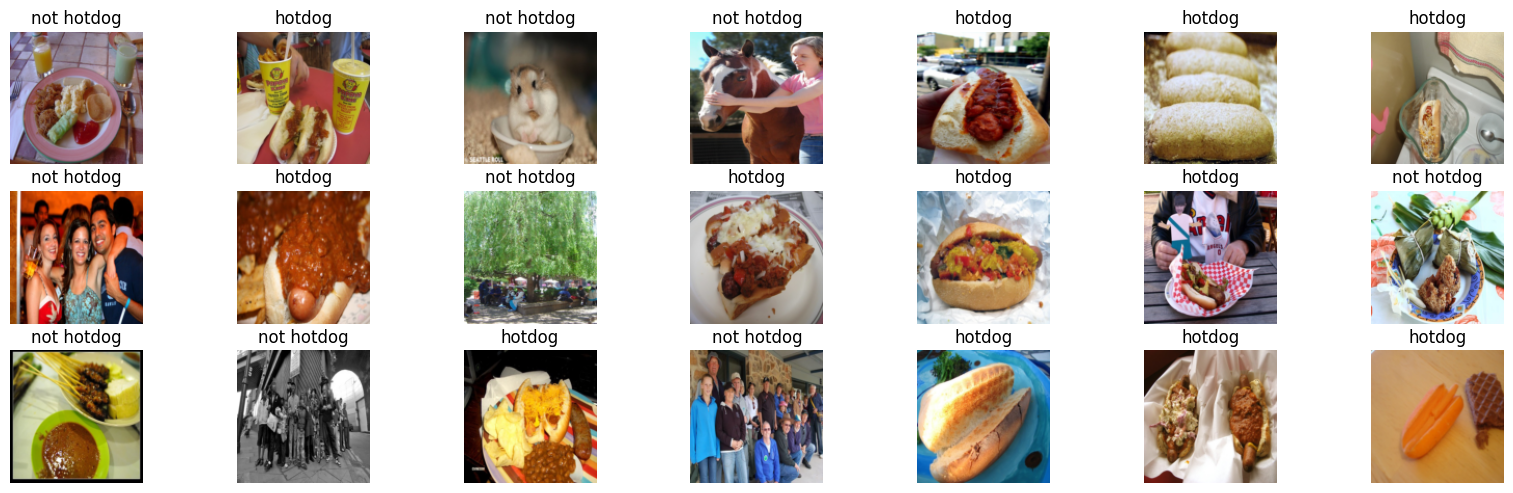

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [6]:
# Implementation from here: https://amaarora.github.io/posts/2020-08-02-densenets.html#denselayer-implementation
class _Transition(nn.Sequential):
        def __init__(self, num_input_features, num_output_features):
            super(_Transition, self).__init__()
            self.add_module('norm', nn.BatchNorm2d(num_input_features, eps=1e-3))
            self.add_module('relu', nn.ReLU(inplace=True))
            self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                            kernel_size=1, stride=1, bias=False))
            self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features, eps=1e-3)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate,eps=1e-3)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        "Bottleneck function"
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    def forward(self, input):  # noqa: F811
        if isinstance(input, torch.Tensor):
            prev_features = [input]
        else:
            prev_features = input

        bottleneck_output = self.bn_function(prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features

class _DenseBlock(nn.ModuleDict):
        def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
            super(_DenseBlock, self).__init__()
            for i in range(num_layers):
                layer = _DenseLayer(
                    num_input_features + i * growth_rate,
                    growth_rate=growth_rate,
                    bn_size=bn_size,
                    drop_rate=drop_rate,
                    memory_efficient=memory_efficient,
                )
                self.add_module('denselayer%d' % (i + 1), layer)
        
        def forward(self, init_features):
                features = [init_features]
                for name, layer in self.items():
                        new_features = layer(features)
                        features.append(new_features)
                return torch.cat(features, 1)

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0.1, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # Convolution and pooling part from table-1
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False),
             nn.BatchNorm2d(num_init_features,eps=1e-3),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # Add multiple denseblocks based on config 
        # for densenet-121 config: [6,12,24,16]
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                # add transition layer between denseblocks to 
                # downsample
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features, eps=1e-3))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)


    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=False)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

def _densenet(arch, growth_rate, block_config, num_init_features,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs, num_classes=2)
    return model

In [7]:
growth_rate = 32
block_config = (3, 6, 12, 8)
num_init_features = 64
model = _densenet('densenet', growth_rate, block_config, num_init_features)

model.to(device)
#Initialize the optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay=0.001)

In [8]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.cross_entropy(output, target)
    out_dict = {
              'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [9]:
out_dict = train(model, optimizer, num_epochs=20)

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.579	 test: 0.714	 Accuracy train: 70.3%	 test: 70.7%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.486	 test: 0.545	 Accuracy train: 77.7%	 test: 75.5%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.440	 test: 0.537	 Accuracy train: 81.2%	 test: 77.4%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.418	 test: 0.489	 Accuracy train: 81.5%	 test: 75.8%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.397	 test: 0.564	 Accuracy train: 82.5%	 test: 72.6%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.386	 test: 0.441	 Accuracy train: 83.7%	 test: 80.3%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.373	 test: 0.574	 Accuracy train: 84.1%	 test: 68.2%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.349	 test: 0.675	 Accuracy train: 85.2%	 test: 71.3%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.334	 test: 0.845	 Accuracy train: 85.3%	 test: 71.7%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.323	 test: 0.979	 Accuracy train: 85.8%	 test: 71.1%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.311	 test: 0.439	 Accuracy train: 86.4%	 test: 81.3%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.288	 test: 0.645	 Accuracy train: 88.1%	 test: 73.3%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.268	 test: 0.561	 Accuracy train: 89.0%	 test: 80.9%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.251	 test: 0.497	 Accuracy train: 89.8%	 test: 79.9%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.270	 test: 1.592	 Accuracy train: 88.4%	 test: 57.6%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.231	 test: 1.172	 Accuracy train: 91.2%	 test: 61.8%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.235	 test: 0.564	 Accuracy train: 90.3%	 test: 78.5%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.228	 test: 0.745	 Accuracy train: 91.2%	 test: 77.9%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.240	 test: 0.847	 Accuracy train: 90.0%	 test: 75.5%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.199	 test: 0.680	 Accuracy train: 92.8%	 test: 77.6%


Text(0, 0.5, 'Accuracy')

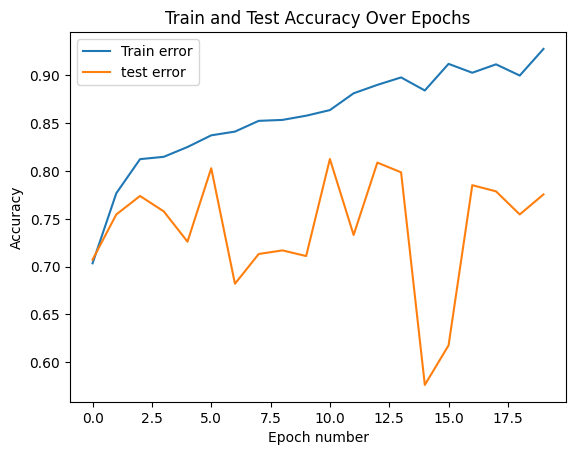

In [11]:
plt.plot(out_dict['train_acc'], label='Train Accuracy')
plt.plot(out_dict['test_acc'], label='Test Accuracy')
plt.title('Train and Test Accuracy Over Epochs')
plt.legend(('Train error','test error'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

In [12]:
model

DenseNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace